<a href="https://colab.research.google.com/github/sagarstormborn/star_gan_final_year/blob/main/STAR_GAN_Models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
ra=torch.randn(5,5, 8,6)

In [40]:
!pip install torch-summary
from torchsummary import summary
import torch.nn as nn 

star gan discriminator .jpg

In [54]:
class con_batch_glu(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding, dilation=1, groups=1, bias=False, padding_mode='zeros'):
    super(con_batch_glu,self).__init__()
    self.architecture=nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups,bias, padding_mode),
        nn.BatchNorm2d(num_features=out_channels,affine=True, track_running_stats=True),
    )
  
  def forward(self,x):
    x=self.architecture(x)
    x=nn.functional.glu(x,dim=1)
    return x


class Discriminator(nn.Module):

  def __init__(self): 
    super(Discriminator,self).__init__()
    self.para=[[32,(3,9),(1,1),(1, 4)],[32,(3,8),(1,2),(1, 3)],[32,(3,8),(1,2),(1, 3)],[32,(3,6),(1,2),(1, 2)]]

    in_channels=5
    i=0 #layer 1
    self.layer1=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +4
    i+=1
    self.layer2=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +4
    i+=1
    self.layer3=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +4
    i+=1
    self.layer4=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 


    self.layer_con=nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=(36,5), stride=(36,1), padding=(1,2))
    self.pool=nn.AvgPool2d(kernel_size=(1,64))
    

  def forward(self,x,c):
    c=c.view(c.shape[0],1,c.shape[1],c.shape[2]) # shape (nx1x4x4)

    c1=c.repeat(1,4,9,128) #shape [n , 4, 512, 36]
    x=torch.cat([x, c1], dim=1)
    x=self.layer1(x)

    c1=c.repeat(1,4,9,128) #shape [n , 4, 512, 36]
    x=torch.cat([x, c1], dim=1)
    x=self.layer2(x)

    c1=c.repeat(1,4,9,64) #shape [n , 4, 256, 36]
    x=torch.cat([x, c1], dim=1)
    x=self.layer3(x)

    c1=c.repeat(1,4,9,32) #shape [n , 4, 32, 36]
    x=torch.cat([x, c1], dim=1)
    x=self.layer4(x)

    x=self.layer_con(x)

    x=torch.sigmoid(x)
    x=self.pool(x)
    return x





In [ ]:
summary(Discriminator(),[(1,36,512),(4,4)])

In [ ]:
c=torch.randn(5,4,4).to("cuda")
x=torch.randn(5,1,36,512).to("cuda")
gen=Discriminator().to("cuda")
gen(x,c).shape

torch.Size([5, 1, 1, 1])

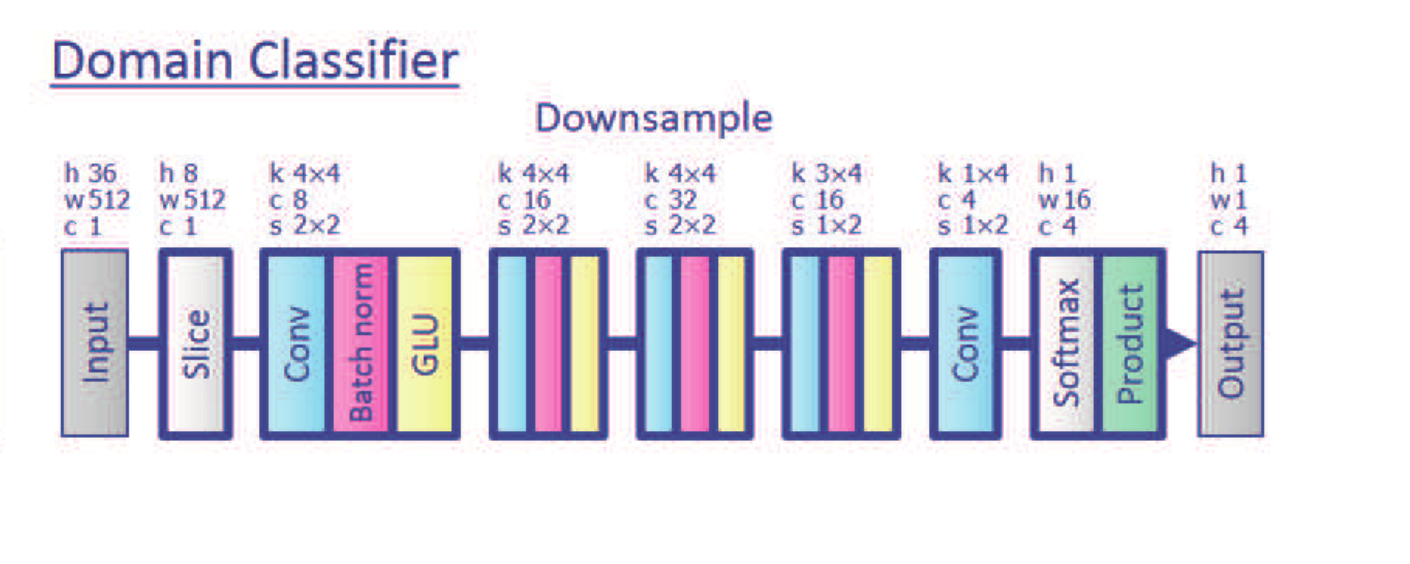

In [ ]:
class Domain(nn.Module):
  def __init__(self):
    super(Domain,self).__init__()
    self.para=[[8,(4,4),(2,2),(5, 1)],[16,(4,4),(2,2),(1,1)],[32,(4,4),(1,2),(0,1)],[16,(3,4),(1,2),(1,1)]]

    layers=[]
    in_channels=1
    for i in range(len(self.para)):
      layers.append(con_batch_glu(in_channels,*self.para[i]))
      in_channels=self.para[i][0]//2

    self.architecture=nn.Sequential(*layers)
    self.architecture.add_module("conv",nn.Conv2d(in_channels, out_channels=4, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1) ))
    self.architecture.add_module("softmax", nn.Softmax(dim=-1))
    self.architecture.add_module("pooling",nn.AvgPool2d((1, 16)) )

  def forward(self,x):
    x=x[:,:,0:8,:]
    x=self.architecture(x)
    return x

In [ ]:
summary(Domain(),[(1,36,512)])

In [ ]:
x=torch.randn(5,1,36,512).to("cuda")
dom=Domain().to("cuda")
dom(x).shape

torch.Size([5, 4, 1, 1])

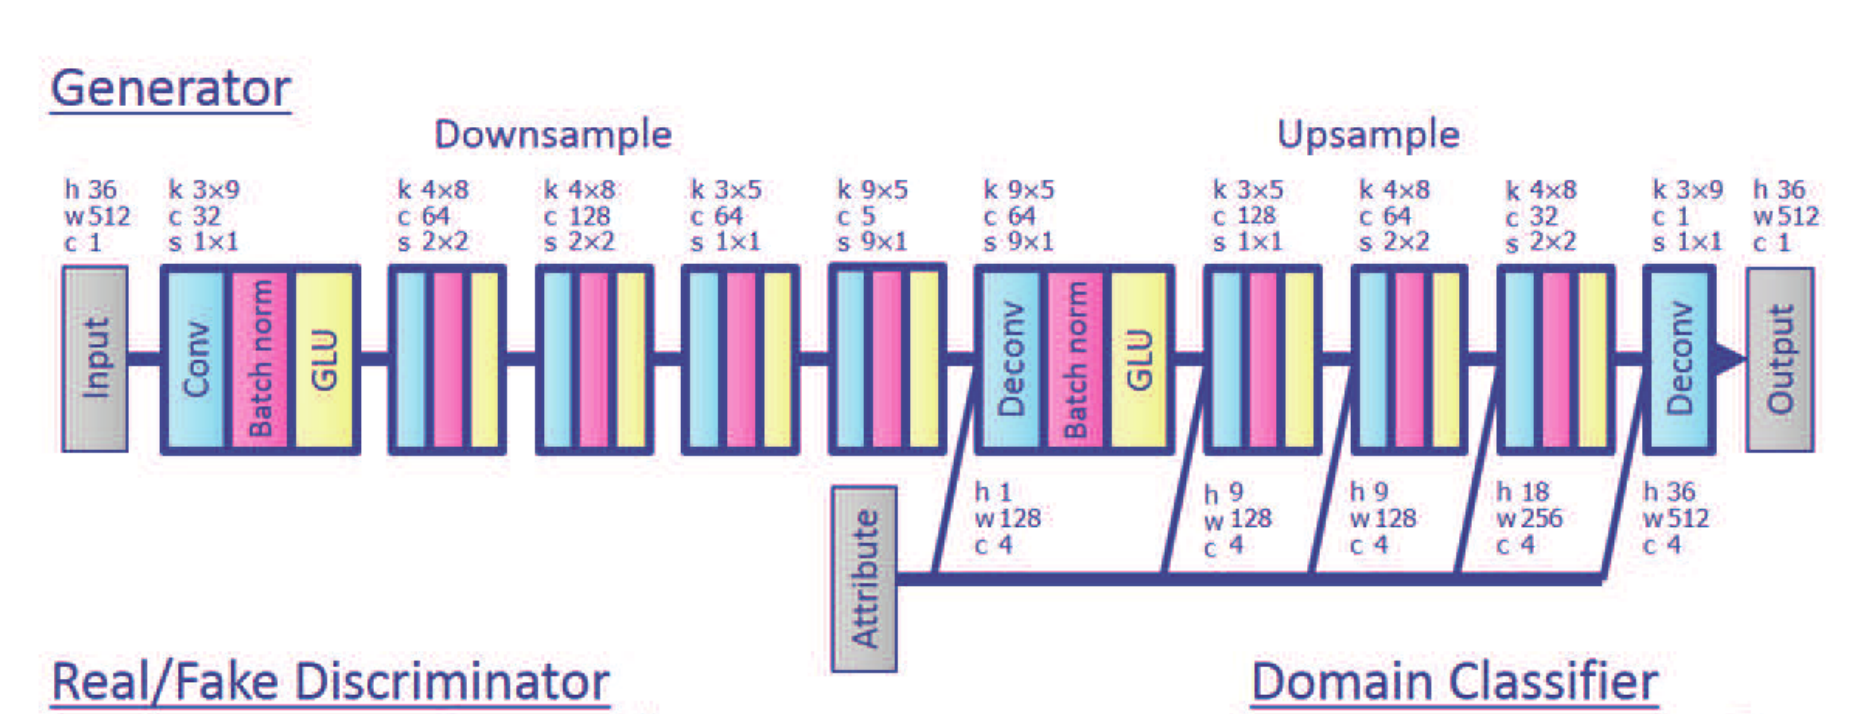

In [140]:

class decon_batch_glu(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding, output_padding=0, groups=1, bias=False, dilation=1, padding_mode='zeros'):
    super(decon_batch_glu,self).__init__()
    self.architecture=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride,padding, output_padding, groups, bias, dilation, padding_mode),
        nn.BatchNorm2d(num_features=out_channels,affine=True, track_running_stats=True),
    )
  
  def forward(self,x):
    x=self.architecture(x)
    x=nn.functional.glu(x,dim=1)
    return x


class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.para=[[32,(3,9),1,(1, 4)],[64,(4,8),(2,2),(1, 3)],[128,(4,8),(2,2),(1,3)],[64,(3,5),(1,1),(1,2)],[10,(9,5),(9,1),(1,2)]]

    layers=[]
    in_channels=1
    for i in range(len(self.para)):
      layers.append(con_batch_glu(in_channels,*self.para[i]))
      in_channels=self.para[i][0]//2

    self.para_1=[[64,(9,5),(9,1),(0, 2)],[128,(3,5),1,(1, 2)],[64,(4,8),(2,2),(1, 3)],[32,(4,8),(2,2),(1, 3)]]

    i=0 #layer 1
    in_channels+=4
    self.layer1=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1

    self.layer2=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1

    self.layer3=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1

    self.layer4=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +4
    i+=1
    
    self.architecture=nn.Sequential(*layers)
    
    self.decon=nn.ConvTranspose2d(in_channels, out_channels=1, kernel_size=(3, 9), stride=(1, 1), padding=(1,4) )

    
  def forward(self,x,c):
    x=self.architecture(x)
    c=c.view(c.shape[0],c.shape[1],1,c.shape[2]) # shape (nx1x4x4)

    c1=c.repeat(1,1,1,32) #shape [n , 1, 1,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer1(x)

    c1=c.repeat(1,1,9,32) #shape [n , 1, 9,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer2(x)

    c1=c.repeat(1,1,9,32) #shape [n , 1, 9,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer3(x)

    c1=c.repeat(1,1,18,64) #shape [n , 1,18,256]
    x=torch.cat([x, c1], dim=1)
    x=self.layer4(x)

    c1=c.repeat(1,1,36,128) #shape [n ,1,36,512]
    x=torch.cat([x, c1], dim=1)

    x=self.decon(x)

    return x

In [141]:
summary(Generator(),[(1,36,512),(4,4)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 5, 1, 128]           --
|    └─con_batch_glu: 2-1                [-1, 16, 36, 512]         --
|    |    └─Sequential: 3-1              [-1, 32, 36, 512]         928
|    └─con_batch_glu: 2-2                [-1, 32, 18, 256]         --
|    |    └─Sequential: 3-2              [-1, 64, 18, 256]         32,896
|    └─con_batch_glu: 2-3                [-1, 64, 9, 128]          --
|    |    └─Sequential: 3-3              [-1, 128, 9, 128]         131,328
|    └─con_batch_glu: 2-4                [-1, 32, 9, 128]          --
|    |    └─Sequential: 3-4              [-1, 64, 9, 128]          61,568
|    └─con_batch_glu: 2-5                [-1, 5, 1, 128]           --
|    |    └─Sequential: 3-5              [-1, 10, 1, 128]          14,420
├─decon_batch_glu: 1-2                   [-1, 32, 9, 128]          --
|    └─Sequential: 2-6                   [-1, 64, 9, 128]          

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 5, 1, 128]           --
|    └─con_batch_glu: 2-1                [-1, 16, 36, 512]         --
|    |    └─Sequential: 3-1              [-1, 32, 36, 512]         928
|    └─con_batch_glu: 2-2                [-1, 32, 18, 256]         --
|    |    └─Sequential: 3-2              [-1, 64, 18, 256]         32,896
|    └─con_batch_glu: 2-3                [-1, 64, 9, 128]          --
|    |    └─Sequential: 3-3              [-1, 128, 9, 128]         131,328
|    └─con_batch_glu: 2-4                [-1, 32, 9, 128]          --
|    |    └─Sequential: 3-4              [-1, 64, 9, 128]          61,568
|    └─con_batch_glu: 2-5                [-1, 5, 1, 128]           --
|    |    └─Sequential: 3-5              [-1, 10, 1, 128]          14,420
├─decon_batch_glu: 1-2                   [-1, 32, 9, 128]          --
|    └─Sequential: 2-6                   [-1, 64, 9, 128]          

In [142]:
x=torch.randn(5,1,36,512).to("cuda")
c=torch.randn(5,4,4).to("cuda")
gen=Generator().to("cuda")
gen(x,c).shape

torch.Size([5, 1, 36, 512])